# Generación de word embeddings
Se van a generar los word embeddings usando FastText de Gensim

Lo primero es cargar los embeddings en un formato que lo pueda leer Gensim. Se usa el método Text8Corpus como hack.

Basado en el ejemplo de http://migsena.com/build-and-visualize-word2vec-model-on-amazon-reviews/

In [26]:
import gensim
import multiprocessing
import numpy as np
import pickle

archivoModelo = 'Vectores.w2v'
archivoComentarios = 'SoloTextos.txt'
sentences = gensim.models.word2vec.Text8Corpus(archivoComentarios)

## Entrenamiento de los embeddings
Se entrena el modelo de FastText con las oraciones cargadas. 

Se guarda el modelo y además, se generan 2 archivos: el vocabulario y sus embeddings respectivos. Estos se cargaran en la CNN.

In [2]:
#Dimensionality of the resulting word vectors
num_features = 128
#Minimum word count threshold
min_word_count = 2
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
#Context window length
context_size = 5
#Seed for the RNG, to make the result reproducible
seed = 1

modelo = gensim.models.FastText(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

modelo.build_vocab(sentences=sentences)
print("Vocabulario construido")
print("Tamaño de vocabulario de Word2Vec: ", len(modelo.wv.vocab))
#Start training the model
print("Inicio entrenamiento")
modelo.train(sentences=sentences,total_examples=modelo.corpus_count, epochs=50)
print("Fin entrenamiento")
modelo.save(archivoModelo)

#Va a extraer el vocabulario y sus emebddings y exportarlos en dos archivos separados 
#para poder ser usados en tensorflow
vocab = modelo.wv.vocab
embeddings = np.array([modelo.wv.get_vector(k) for k in vocab.keys()])
with open('fasttext_vocabulario.dat', 'wb') as fw:
    pickle.dump(vocab, fw, protocol=pickle.HIGHEST_PROTOCOL)
np.save('fasttext_embeddings.npy', embeddings)

print("Modelo guardado")

Vocabulario construido
Tamaño de vocabulario de Word2Vec:  5436
Inicio entrenamiento
Fin entrenamiento
Modelo guardado


## Representación gráfica de los embeddings

Se va visualizar los datos usando t-SNE. t-SNE es una herramienta de visualización que reduce la dimensionalidad a 2 o 3 dimensiones para graficar. 

El algoritmo tiene una complejidad cuadrática, por lo que se toma solo una muestra de 10 000 palabras (en nuestro ejemplo tenemos menos de 5 500, entonces se toma toda la muestra completa).

In [36]:
modelo = gensim.models.word2vec.Word2Vec.load(archivoModelo)  # Cargar el modelo ya entrenado
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, num_features), dtype='float64')
word_list = []
i = 0
for word in modelo.wv.vocab:
    word_vectors_matrix[i] = modelo[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 128)


C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Se comprimen los embeddings a solo 2 vectores, se buscan similaridades entre puntos y probabilidades similares y agrupa los datos. Los resultados pueden variar.

In [38]:
#Compress the word vectors into 2D space
"""
t-SNE [1] is a tool to visualize high-dimensional data. 
It converts similarities between data points to joint probabilities and tries to minimize 
the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding 
and the high-dimensional data. t-SNE has a cost function that is not convex, 
i.e. with different initializations we can get different results.
"""
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [39]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head((10))

Points DataFrame built


,word,x,y
0,salg,-7.021949,-2.565482
1,de,-11.033061,-7.710304
2,veotv,-18.762508,-3.449470
3,que,-13.292398,-2.783387
4,dia,-21.499506,-9.330791
5,mas,-1.927640,2.511772
6,pauladelasher,-16.811096,-14.539165
7,no,-12.989833,-2.345824
8,te,-19.921408,-2.460757
9,libr,-19.323549,-5.543302


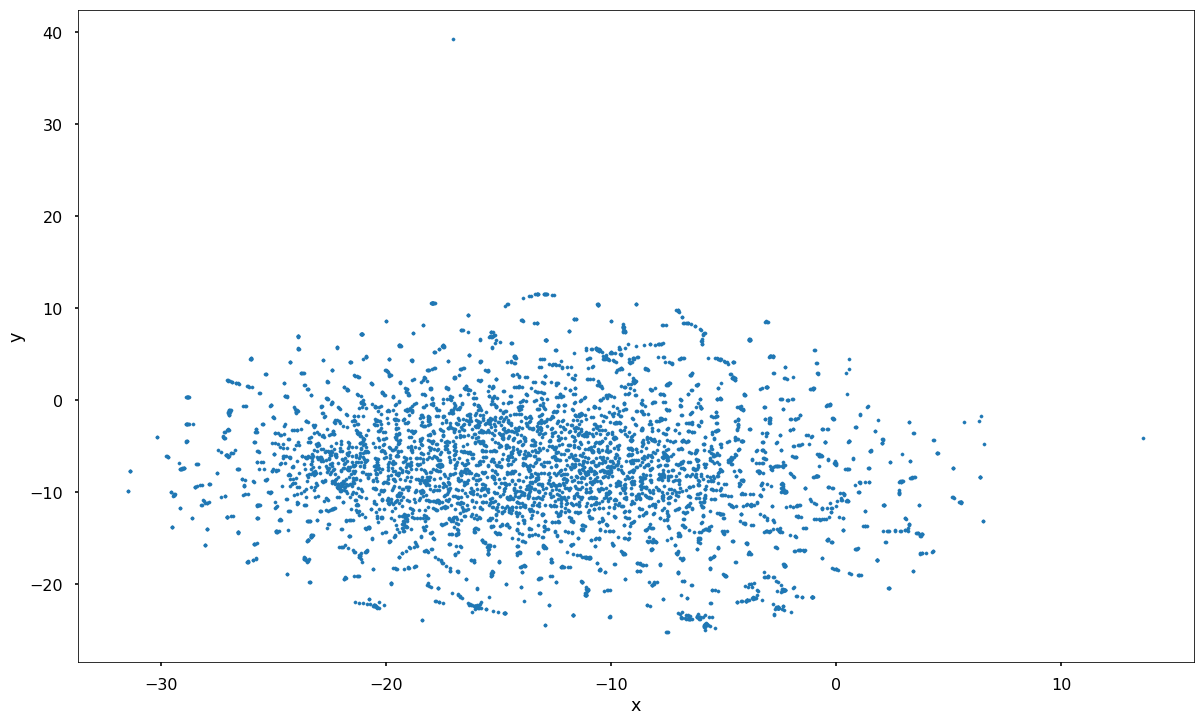

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

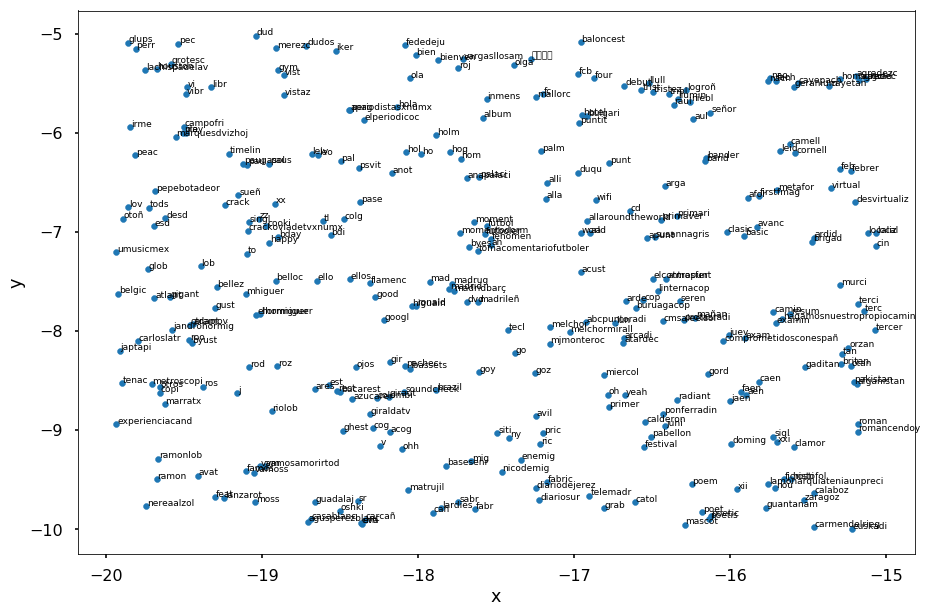

In [41]:
def plot_region (x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 10))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=9)
    
plot_region(x_bounds=(-20, -15), y_bounds=(-10, -5))

In [42]:
modelo.wv.most_similar("feliz")

[('felizxnumx', 0.6736035943031311),
 ('felicesfiest', 0.6357923746109009),
 ('felic', 0.6231204271316528),
 ('felicitar', 0.5534031987190247),
 ('felicit', 0.5517969131469727),
 ('nochebuen', 0.5397328734397888),
 ('cumpleañ', 0.5270272493362427),
 ('bday', 0.5249808430671692),
 ('happy', 0.5157582759857178),
 ('pabloalbor', 0.51043301820755)]